<a href="https://colab.research.google.com/github/jrakhshanda/Deep-Learning/blob/master/trafficSign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle --upgrade

In [ ]:
# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"rakhshandajabeen55","key":"2483f350dd73f648b655ddd3456c3ce1"}
import json
import zipfile
import os
!chmod 600 /root
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config path -p /content
!kaggle competitions download -c sweden-traffic-signs-classification
os.chdir('/content/')

In [ ]:
from zipfile import ZipFile
with ZipFile('/content/data.zip', 'r') as zipObj:
    print(zipObj)
    zipObj.extractall("data")

In [49]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf 

from keras.models import Sequential
from keras.layers import  Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import random
from matplotlib import pyplot
from matplotlib import cm

In [23]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

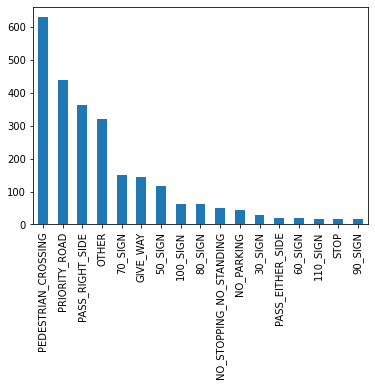

In [24]:
train["label"].value_counts().plot(kind = "bar")

In [25]:
train, validate = train_test_split(train, test_size=0.30, random_state=20)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)
train_generator = train_datagen.flow_from_dataframe(
    train, 
    "/content/data/data", 
    x_col='file_name',
    y_col='label',
    target_size=(32,32),
    class_mode='categorical',
    batch_size=32 
)

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate, 
    "/content/data/data/", 
    x_col='file_name',
    y_col='label',
    target_size=(32,32),
    class_mode='categorical',
    batch_size=32
)

In [74]:
def createModel( num_classes,image_shape, chanDim):
  model = Sequential()
  
# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
  model.add(Conv2D(16,kernel_size=(3,3),activation= "relu",input_shape = image_shape))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Conv2D(16,kernel_size=(3,3),activation= "relu",input_shape = image_shape))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPool2D(pool_size=(2,2))) 

# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
  model.add(Conv2D(32,kernel_size=(3,3),activation= "relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Conv2D(32,kernel_size=(3,3),activation= "relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPool2D(pool_size=(2,2)))

# first set of FC => RELU layers
  model.add(Conv2D(64,kernel_size=(3,3),activation= "relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

# first set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(128,activation= 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  
# second set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(128,activation= 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  
  model.add(Dense(num_classes,activation='softmax'))
  model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.RMSprop(learning_rate= 0.001),metrics = ['accuracy'])

  return model
batch_size = 128
num_classes = 17
chanDim = -1
image_shape = (32,32,3)
model = createModel(num_classes,input_shape,chanDim)

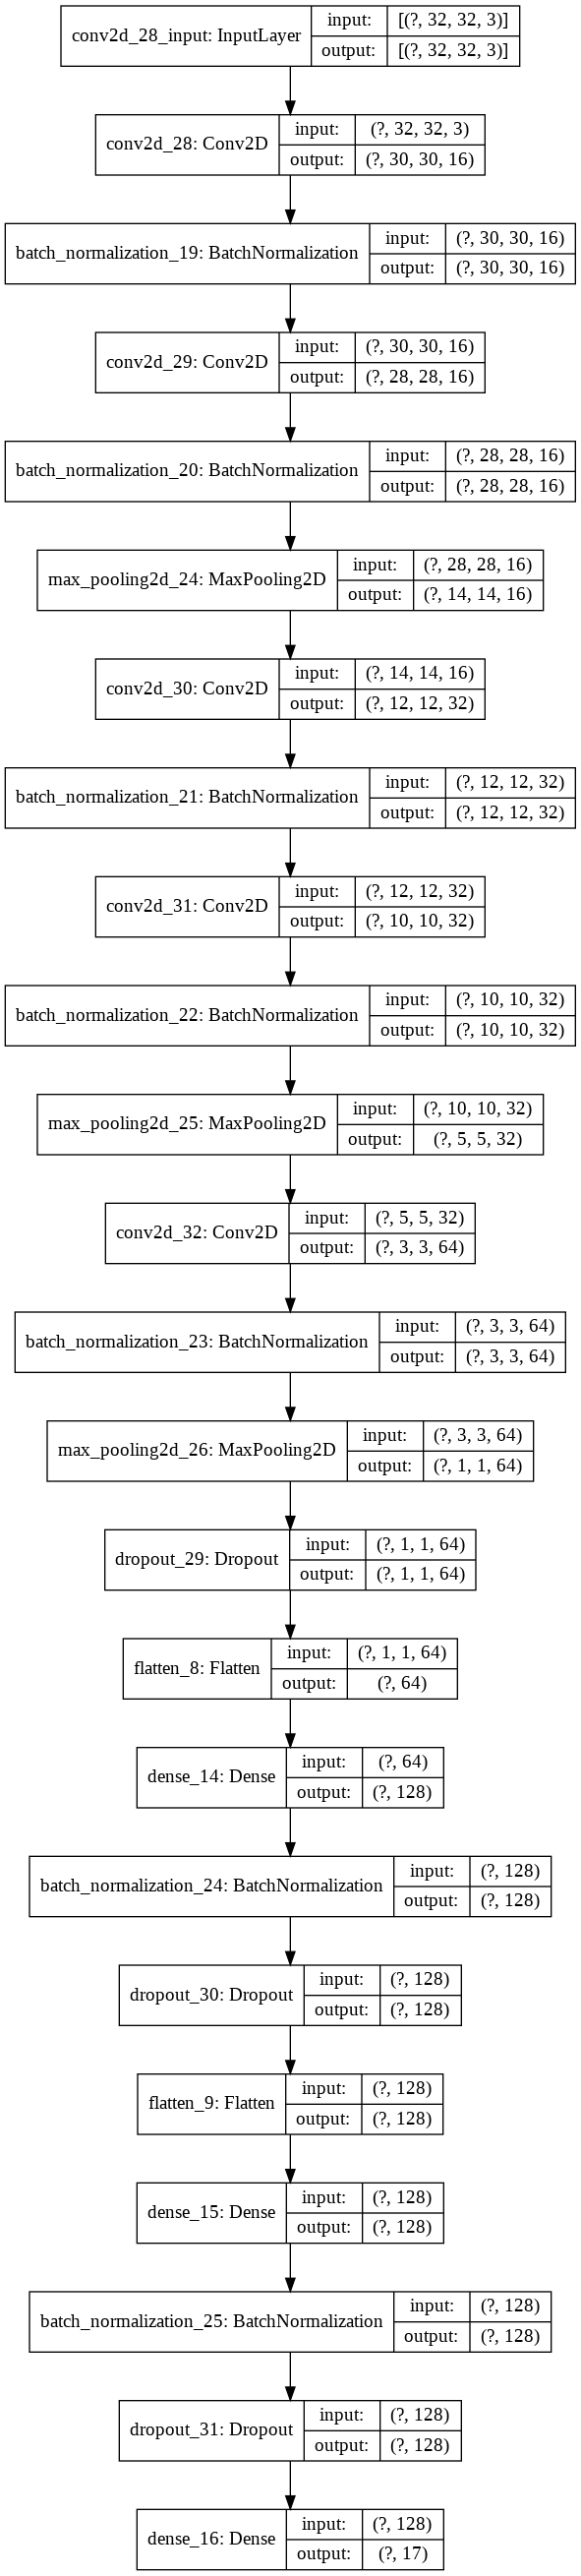

In [75]:
keras.utils.plot_model(model,show_shapes= True,show_layer_names=True)

In [76]:
earlyStop = EarlyStopping(patience = 10)
variable_gradient = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=0.001)

In [ ]:
epochs = 30
hist = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[earlyStop,variable_gradient]
)

Epoch 1/30
55/55 [==============================] - 3s 46ms/step - loss: 0.8430 - accuracy: 0.7329 - val_loss: 0.7101 - val_accuracy: 0.7510
Epoch 2/30
55/55 [==============================] - 2s 45ms/step - loss: 0.8195 - accuracy: 0.7329 - val_loss: 0.5830 - val_accuracy: 0.8202
Epoch 3/30
55/55 [==============================] - 2s 45ms/step - loss: 0.8207 - accuracy: 0.7460 - val_loss: 0.6023 - val_accuracy: 0.8069
Epoch 4/30
55/55 [==============================] - 2s 44ms/step - loss: 0.8366 - accuracy: 0.7306 - val_loss: 0.5811 - val_accuracy: 0.8069
Epoch 5/30
55/55 [==============================] - 2s 45ms/step - loss: 0.7445 - accuracy: 0.7580 - val_loss: 0.5444 - val_accuracy: 0.8336
Epoch 6/30
55/55 [==============================] - 2s 45ms/step - loss: 0.7446 - accuracy: 0.7700 - val_loss: 0.6423 - val_accuracy: 0.8189
Epoch 7/30
26/55 [=============>................] - ETA: 1s - loss: 0.7371 - accuracy: 0.7561

In [41]:
model.save('trafficSign')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: trafficSign/assets


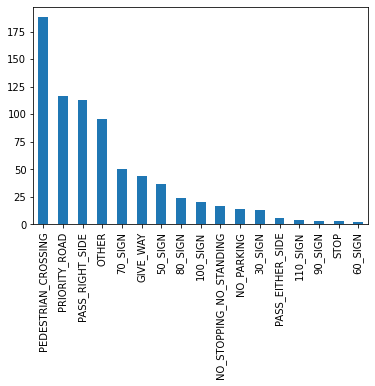

In [141]:
validate["label"].value_counts().plot(kind = "bar")

In [136]:
test.head()

,file_name
0,picture-176290.jpg
1,picture-834444.jpg
2,picture-768882.jpg
3,picture-212331.jpg
4,picture-277367.jpg


In [138]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test, 
    "/content/data/data/", 
    x_col='file_name',
    y_col=None,
    target_size=(70,70),
    class_mode=None,
    batch_size=32
)

Found 610 validated image filenames.


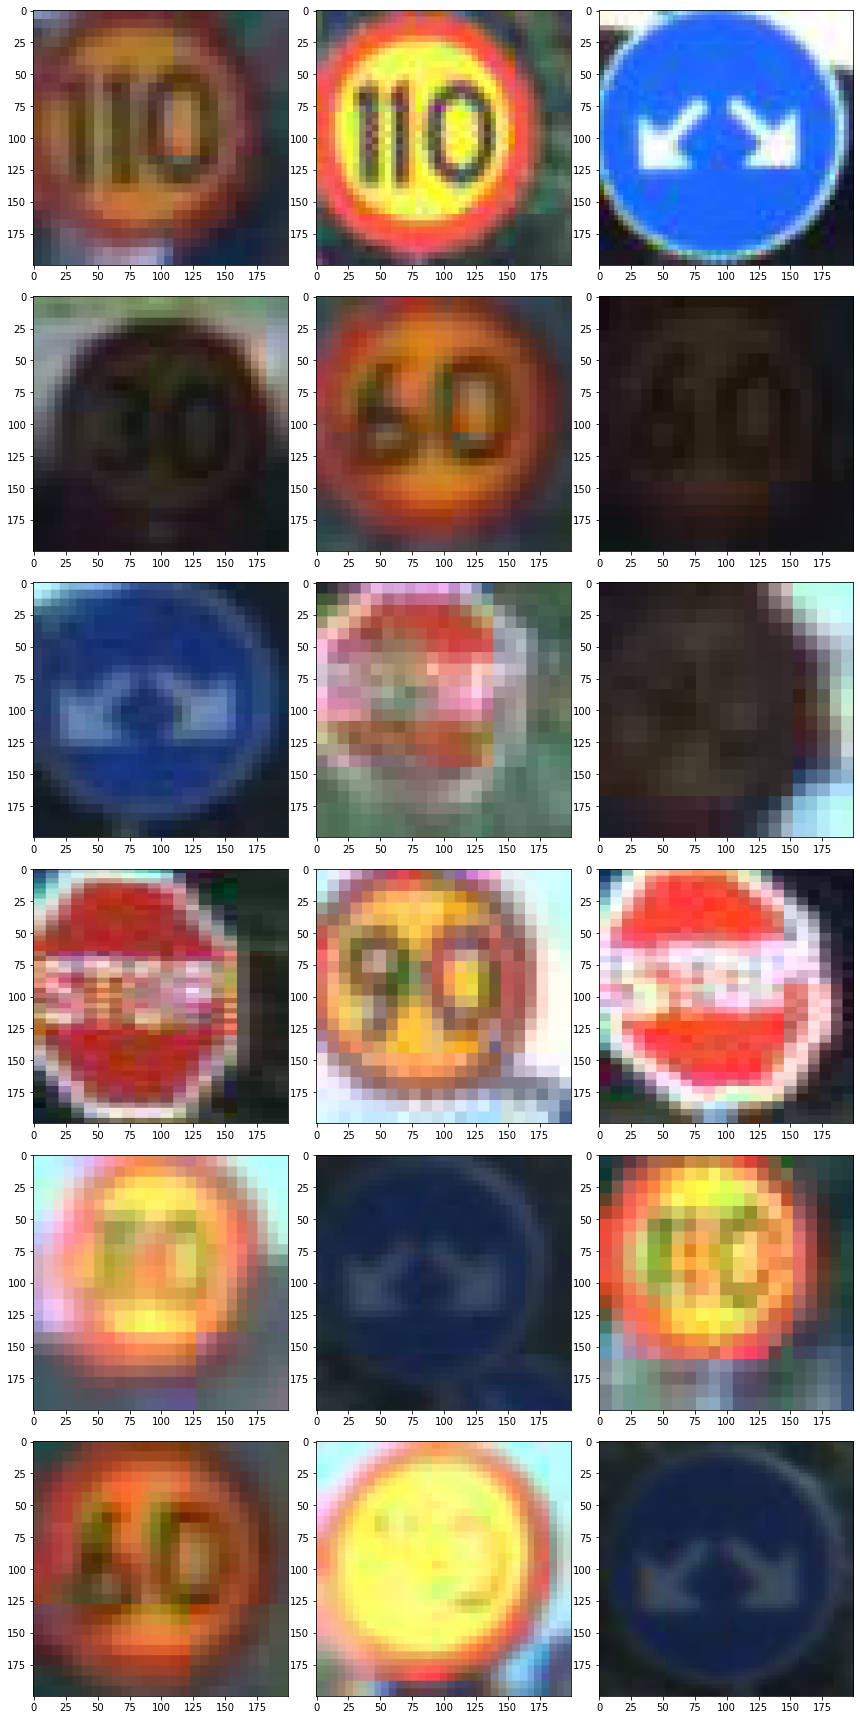

In [149]:
sample_test = test.head(18)
sample_test.head()
pyplot.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['file_name']
    img = load_img("/content/data/data/"+filename, target_size=(200,200))
    pyplot.subplot(6, 3, index+1)
    pyplot.imshow(img)
pyplot.tight_layout()
pyplot.show()